In [1]:
# Figure 7
## Spatial distribution and impact relevance of dominant WTs associated with HIPEs in the Alps

In [2]:
library(synoptReg)
library(tidyverse)
library(metR)
library(terra)
library(giscoR)
library(legendry)
library(sf)
library(cptcity)

setwd("/mnt/CEPH_PROJECTS/HIPEAtMount/HIPEAtMount-WP1")
source("Script/Functions/theme_plot.R")


****
Welcome to synoptReg! 
Using synoptReg for research publication?  Please cite it!
Lemus-Canovas, M. et al. synoptReg: An R package for computing a synoptic climate classification and a spatial regionalization of environmental data. 
Environmental Modelling & Software 118, 114-119 (2019). DOI: https://doi.org/10.1016/j.envsoft.2019.04.006.
****


── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.2     ✔ tibble    3.3.0
✔ lubridate 1.9.4     ✔ tidyr     1.3.1
✔ purrr     1.1.0     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors

Attaching package: ‘metR’


The following object is masked from ‘package:purrr’:

    cross


terra 1.8.60


Attaching pa

In [3]:
## ---- Borders & geographic context ----------------------------------------
# Getting Alpine and neighboring borders
borders <- giscoR::gisco_get_countries(country = c(
  "Italy","Switzerland","France","Austria","Slovenia",
  "Germany","Croatia","Bosnia"
), resolution = "03")

world <- giscoR::gisco_coastallines

borders_w_nuts <- giscoR::gisco_get_nuts(year = 2021, resolution = "03", nuts_level = 0) %>%
    st_transform(crs = st_crs(borders))

# Alpine convention borders
borders_convention <- read_sf("Data/Borders/Alpine_Convention_Perimeter_2018_v2/Alpine_Convention_Perimeter_2018_v2.shp") %>%
  st_transform(crs = st_crs(borders)) %>%
  st_make_valid()



# HISTALP borders
HISTALP_borders <- read_sf("Data/Borders/Shape_CRSM/Shape_CRSM.shp") %>%
  st_transform(crs = st_crs(borders)) %>%
  st_make_valid()

# Intersecting HISTALP with Alpine convention borders
GAR_HISTALP_intersect <- st_intersection(borders_convention, HISTALP_borders) %>% 
  dplyr::select(Id.1) %>% 
  dplyr::rename(Regions = Id.1) %>%
  mutate(
    Regions = ifelse(Regions == 0, "Southwest", Regions),
    Regions = ifelse(Regions == 1, "Northwest", Regions),
    Regions = ifelse(Regions == 2, "Northeast", Regions),
    Regions = ifelse(Regions == 3, "Southeast", Regions)
  )

# River network in the Alpine convention
rivers <- rnaturalearth::ne_download(scale = 10, type = 'rivers_lake_centerlines', category = 'physical') %>%
  st_intersection(borders_convention)

# Extent ALpine region
sample_4_extent <- rast("Data/APGD/harmonised/RapdD_al05_19710100_harm.nc")[[1]]
extent <- ext(sample_4_extent)

Warning message:
“attribute variables are assumed to be spatially constant throughout all geometries”
Reading ne_10m_rivers_lake_centerlines.zip from naturalearth...
Warning message:
“attribute variables are assumed to be spatially constant throughout all geometries”


In [4]:
# Read Weather types -----------------------------------------------------
cl <- read_csv("Output/Data/3_Predictors/Temporal/weather_types_HIPEs_vol2.csv")

frequency_cl <- table(cl$WT)

# Order cl WTs by frequency
cl$WT <- factor(cl$WT, levels = names(sort(frequency_cl, decreasing = T)))

percentage_cl <- round(frequency_cl/sum(frequency_cl) * 100,1)

# Order frequency_cl by frequency
frequency_cl <- frequency_cl[order(frequency_cl, decreasing = T)]

# Order percentage_cl by frequency
percentage_cl <- percentage_cl[order(frequency_cl, decreasing = T)]

# Create a data frame with the frequency and percentage of each WT
WTs_labels <- paste0(levels(cl$WT)," | ", frequency_cl, " (",percentage_cl,"%)")



Rows: 1364 Columns: 2
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr  (1): WT
date (1): time

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


In [5]:
# Link precipitation maps -------------------------------------------------
epe_db_prmsaw_grid <- read_rds("Output/Data/2_ranking_databases/prmsaw_complete_ranking/prmsaw_EPEdb_Ranking_zthr10_1961-2022_gridded.rds") 
epe_db_prmsaw_grid_thr <- read_rds("Output/Data/2_ranking_databases/prmsaw_complete_ranking/prmsaw_EPEdb_Ranking_threshold_nevents_z10_1961-2022_gridded.rds")
n_events <- cl$time %>% length()

cl_epes_pr <- inner_join(cl,select(epe_db_prmsaw_grid,time,lat,lon,P_H)) %>%
  inner_join(select(epe_db_prmsaw_grid_thr, -Events)) %>%
  group_by(lon,lat) %>%
  mutate(total_EPEs = sum(P_H >= Thr)) %>% # total number of epes per grid cell 
  group_by(lon,lat,WT) %>%
  mutate(N_EPEs_WT = sum(P_H >=Thr)) %>%# how many epes fall in each wt with respect total EPEs
  ungroup() %>%
  mutate(Prob_EPE = N_EPEs_WT/total_EPEs) %>%
  distinct(lon,lat,WT,.keep_all = T) 

# Extract the WT with the highest probability of EPE
cl_epes_pr <- cl_epes_pr %>%
  group_by(lon,lat) %>%
  filter(Prob_EPE == max(Prob_EPE)) %>%
  ungroup()

n_points <- cl_epes_pr %>% group_by(lon,lat) %>% summarise(n = n()) %>% nrow()

Joining with `by = join_by(time)`
Joining with `by = join_by(lat, lon)`
`summarise()` has grouped output by 'lon'. You can override using the `.groups`
argument.


In [6]:
muted_palette <- c(
  "#E64B35FF",
  "#4DBBD5FF",
  "#00A087FF",
  "#3C5488FF",
  "#F39B7FFF",
  "#8491B4FF",
  "#91D1C2FF",
  "#B09C85FF"
)

# Area (%) covered by each max WT
cl_epes_pr_perc <- cl_epes_pr %>%
  group_by(WT) %>%
  summarise(Area = n()/n_points*100) %>%
  arrange(desc(Area))

# reorder(WT,-Area) # good to reorder quickly a ggplot
bars_perc <- ggplot(data = cl_epes_pr_perc, aes(x = WT, y = Area, fill = WT))+
  geom_bar(stat = "identity")+
  scale_fill_manual(values = muted_palette)+
  scale_y_reverse(breaks = seq(0,30,5),expand = c(0,0))+
  scale_x_discrete(position = "top")+
  theme_void()+
  labs(x = "Weather Type", y = "%", subtitle = "a) Area")+
  theme(axis.text.x = element_text(size = 8,angle = 0, hjust = .5),
        axis.line.y = element_line(color = "black"),
        axis.text.y = element_text(size = 8,hjust = 1),
        axis.title.y = element_text(size = 8,angle = 90, hjust = 0.5, vjust = 2),
        legend.position = "none",
        plot.subtitle = element_text(size = 8))

In [7]:

## Compute cumulated 5 years frequency on cl$clas_pn

# Step 1: Define 5-year bins explicitly
cl_freq <- cl_freq <- cl %>%
  mutate(year = year(time),
         period = cut(year, 
                      breaks = seq(1961, max(year) + 3, by = 3), 
                      labels = paste0(seq(1961, max(year), by = 3), "-", seq(1965, max(year) +2, by = 3)), 
                      include.lowest = TRUE)) %>%
  
  group_by(period, WT) %>%
  summarise(frequency = n(), .groups = "drop") %>%
  complete(period, WT, fill = list(frequency = 0)) %>%
  mutate(year_start = as.numeric(substr(period, 1, 4)))  # Extract starting year of the period

In [8]:
# Flood analysis vs WTs ---------------------------------------------------

# PREPARING HANZE DATABASE-------------------------------------------------------------------------
sf_use_s2(FALSE)
HANZE <- read_csv("Data/HANZE/HANZE_events.csv") 
HANZE_2021db_eu <- read_sf("Data/HANZE/HANZE_floods_regions_2021/HANZE_floods_regions_2021.shp") 

HANZE_2021db_alps <- HANZE_2021db_eu %>%
  st_transform(st_crs(borders_convention)) %>%
  st_intersection(borders_convention) %>%
  select(ID,Country,Year,Type,Region2021,Area,Fatalities,LossesEuro,Cause,
         Start_D,Start_M,Start_Y,End_D,End_M,End_Y) %>%
  filter(Start_Y >= 1961) %>%
  unite(c(Start_D,Start_M,Start_Y), col = "Flood_Start_date" ,sep = "-",remove = T) %>%
  unite(c(End_D,End_M,End_Y), col = "Flood_End_date" ,sep = "-",remove = T) %>%
  mutate(Flood_Start_date = dmy(Flood_Start_date),
         Flood_End_date = dmy(Flood_End_date)) 



# Exploring the database  
HANZE_2021db_alps_df <- st_drop_geometry(HANZE_2021db_alps)

annual_floods_fatalities_alpine <- HANZE_2021db_alps_df %>% 
  filter(Type != "Coastal") %>%
  mutate(Year = as.numeric(Year))%>%
  group_by(Year) %>%
  summarise(N_floods = length(ID),
            Fatalities = sum(Fatalities),
  ) %>%
  complete(
    Year = 1961:2020,
    fill = list(N_floods = 0,
                Fatalities = 0)
  ) 

# Ensure both datasets have Date columns in Date format
clas_edited <- cl %>%
  rename(Start_date = time) %>%  # Rename `time` to `Start_date` for consistency
  mutate(End_date = Start_date)  # Assume WT classification is per single day

window_days <- 5  # Finestra temporal després de la pluja

# Perform the left join and filter the corresponding events
match_WTs_flood_impacts <- clas_edited %>%
  left_join(HANZE_2021db_alps_df, by = character()) %>%
  filter(
    # The classified weather type must occur before or during the flood
    Start_date <= Flood_End_date &
      
      # The flood event must start within the window_days after the classified day
      (Flood_Start_date >= Start_date & Flood_Start_date <= (End_date + days(window_days))) |
      
      # Consider floods registered 1-2 days before the classified WT
      (Flood_Start_date >= (Start_date - days(2)) & Flood_Start_date <= Start_date)
  ) %>%
  select(Start_date, WT, ID, Country, Year, Type, 
         Region2021, Area, Fatalities, LossesEuro, Cause, Flood_Start_date, Flood_End_date, WT) %>%
  distinct()

floods_WTs <- match_WTs_flood_impacts %>%
  select(Start_date,WT, Type, Fatalities) %>%
  group_by(Start_date) %>%
  mutate(Fatalities = sum(Fatalities)) %>%
  distinct(Start_date,.keep_all = T) 

floods_WTs_completed <- left_join(select(clas_edited, Start_date,WT),floods_WTs) %>%
    mutate(River_flood = ifelse(str_starts(Type,"River"),1,0),
         Flash_flood = ifelse(str_starts(Type,"Flash"),1,0))

# Compute observed probability of flood occurrence (all), river, and flash floods; as well as fatalities per WT
floods_WTs_completed_final <- floods_WTs_completed %>%
  group_by(WT) %>%
  summarise(N_floods = sum(!is.na(Type)),
            N_river_floods = sum(River_flood, na.rm =T),
            N_flash_floods = sum(Flash_flood, na.rm = T),
            N_fatalities = sum(Fatalities>0, na.rm = T),
            T_fatalities = sum(Fatalities, na.rm = T),
            N_events = n()) %>%
  mutate(Prob_flood = N_floods/N_events,
         Prob_river_flood = N_river_floods/N_events,
         Prob_flash_flood = N_flash_floods/N_events,
         Prob_Fatality = N_fatalities/N_events) %>%
  arrange(desc(Prob_flood))


Spherical geometry (s2) switched off

Rows: 2521 Columns: 20
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr  (11): Country code, Country name, Type, Flood source, Regions affected ...
dbl   (7): ID, Year, Area flooded, Fatalities, Persons affected, Losses (nom...
date  (2): Start date, End date

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
although coordinates are longitude/latitude, st_intersection assumes that they
are planar

Warning message:
“attribute variables are assumed to be spatially constant throughout all geometries”
Warning message:
“Using `by = character()` to perform a cross join was deprecated in dplyr 1.1.0.
ℹ Please use `cross_join()` instead.”
Joining with `by = join_by(Start_date, WT)`


In [9]:

# Plotting
floods_WTs_completed_final_4_stacked <- floods_WTs_completed_final %>% select(WT,Prob_river_flood, Prob_flash_flood) %>%
  pivot_longer(cols = c(Prob_river_flood,Prob_flash_flood),
               names_to = "Type",values_to = "Probability")

prob_flood_plot <- ggplot()+
  geom_bar(data = floods_WTs_completed_final_4_stacked, aes(x = WT, y = Probability, fill = Type),stat = "identity")+
  scale_fill_manual(
    values = c("lightblue", "blue"),  # Ensure correct color mapping
    labels = c("Flash", "River")  # Rename legend labels
  )+
  scale_x_discrete(expand = c(0,0))+
  scale_y_continuous(breaks = seq(0,0.5,0.1),expand = c(0,0), limits = c(0,.45))+
  theme_void()+
  labs(x = "Weather Type", y = "Probability", subtitle = "c) Flood")+
  theme(axis.text.x = element_text(size = 8,angle = 0, hjust = .5),
        axis.line.y = element_line(color = "black"),
        axis.text.y = element_text(size = 8,hjust = 1),
        axis.title.y = element_text(size = 8,angle = 90, hjust = 0.5, vjust = 2),
        legend.position = "inside",
        legend.key.size = unit(0.25, "cm"),
        legend.title = element_blank(),
        legend.text = element_text(size = 7),
        legend.position.inside = c(.15,.85),
        plot.subtitle = element_text(size = 8))

# Fatalities
prob_fatal_plot <- ggplot()+
  geom_bar(data = floods_WTs_completed_final, aes(x = WT, y = Prob_Fatality, fill = WT),stat = "identity")+
  scale_fill_manual(values = muted_palette)+
  scale_y_continuous(breaks = seq(0,0.5,0.1),expand = c(0,0), limits = c(0,.45))+
  theme_void()+
  labs(x = "Weather Type", y = "Probability", subtitle = "d) Fatality")+
  theme(axis.text.x = element_text(size = 8,angle = 0, hjust = .5),
        axis.line.y = element_line(color = "black"),
        axis.text.y = element_text(size = 8,hjust = 1),
        axis.title.y = element_text(size = 8,angle = 90, hjust = 0.5, vjust = 2),
        legend.position = "none",
        plot.subtitle = element_text(size = 8))



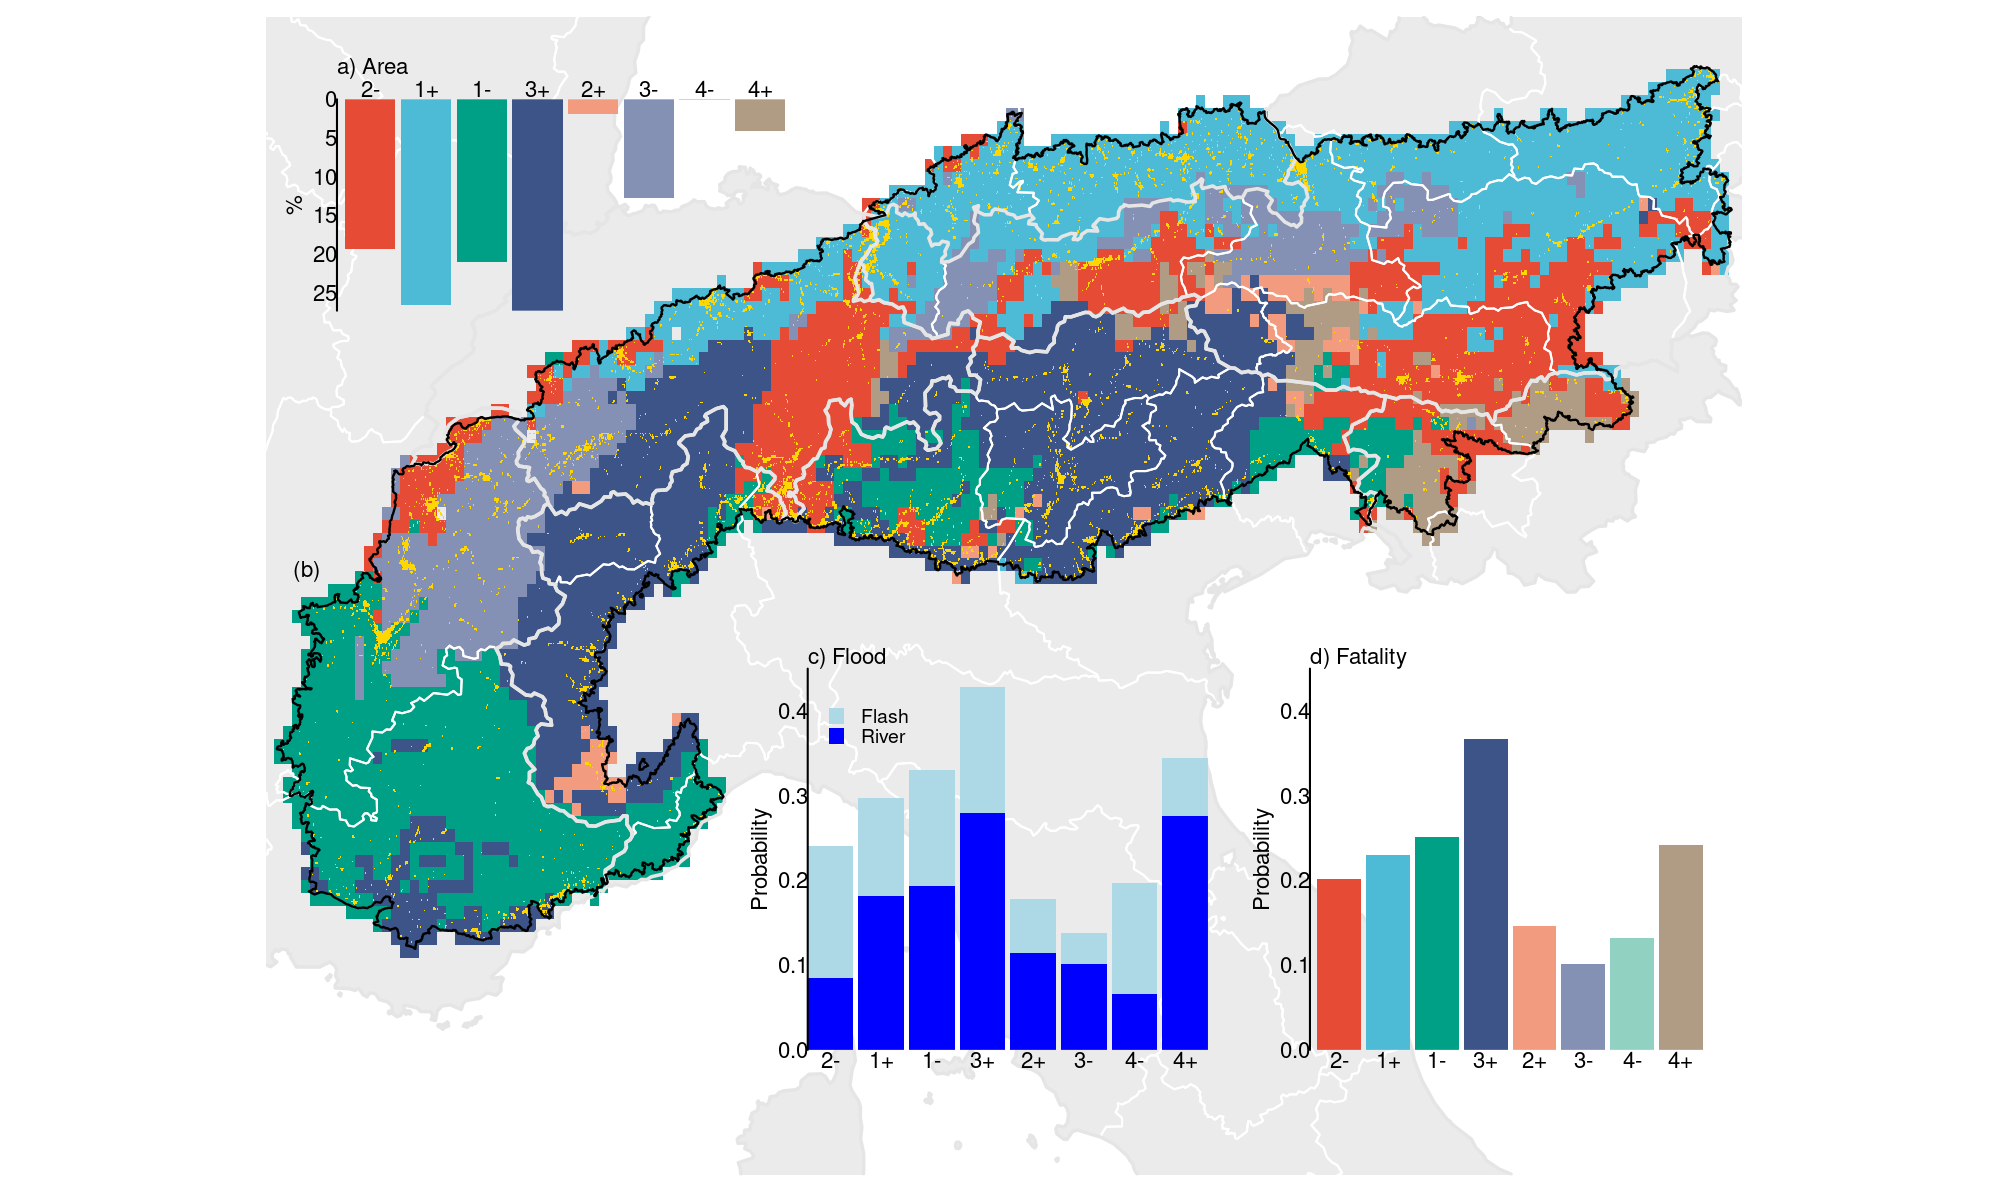

In [12]:
dens_pop <- rast("Data/Density_pop/GlobPOP_Density_30arc_2020_F32.tiff") %>%
  crop(ext(sample_4_extent)) %>%
  mask(borders_convention)

dens_pop_df <- as.data.frame(dens_pop,xy = T) %>% rename("dens"=3) %>%
  mutate(dens = ifelse(dens >500, 1, NA)) %>%
  na.omit()

main <- ggplot()+
  geom_sf(data = borders, fill = "grey92")+
  geom_tile(data = cl_epes_pr, 
            aes(lon, lat, fill = WT))+
  scale_fill_manual(values = muted_palette,
                    name = "Weather Type") +  # Canvi de títol per ser més clar
  ggnewscale::new_scale_fill()+
  geom_tile(data = dens_pop_df, aes(x = x, y = y, fill = as.factor(dens)), alpha = 1) +
  scale_fill_manual(values = "gold") +
  geom_sf(data = borders_w_nuts, fill = "transparent", color = "grey100", linewidth = 0.35)+
  geom_sf(data = borders, color = "grey90", linewidth = 0.6, fill = "transparent")+
  geom_sf(data = borders_convention, fill = "transparent", linewidth = 0.4, color = "black")+
  guides(fill = guide_legend( # Canvi a guide_legend() per dades discretes
    title = "Weather Type",
    title.position = "top",
    nrow = 1,  # Per posar la llegenda en horitzontal
    override.aes = list(size = 3))) +  # Ajust de mida dels símbols de la llegenda
  annotate(
    "text", x = -Inf, y = Inf, label = "(b)", 
    hjust = -1.0, vjust = 35, size = 2.8
  ) +
  labs(y = "Annual precipitation")+
  scale_x_continuous(limits = c(extent[1] + 0.3, extent[2] + 0.1), expand = c(0, 0),
                     breaks = seq(6, 14, 4)) +
  scale_y_continuous(limits = c(extent[3] - 1, extent[4] + 0.15), expand = c(0, 0),
                     breaks = seq(44, 48, 2)) +
  theme_4paper +
  theme(axis.text = element_blank(),
        axis.title.y = element_blank(),
        axis.ticks = element_blank(),
        legend.key.width = unit(0.25, "cm"),
        legend.key.height = unit(0.25, "cm"),
        legend.text.position = "top",
        plot.subtitle = element_blank(),
        panel.border = element_blank(),
        legend.position.inside = c(.1,.96),
        legend.position = "none",# Movem la llegenda a sota
        legend.title = element_text(hjust = 0.5),
        legend.direction = "horizontal",
        legend.key = element_rect(fill = "white", colour = "black"))  # Ajust de l'estil de la llegenda

options(repr.plot.width = 10, repr.plot.height = 6, repr.plot.res = 200)
main +
  annotation_custom(ggplotGrob(bars_perc), xmin = 5, xmax = 9, ymin = 47, ymax = 48.5)+
  # annotation_custom(ggplotGrob(slope_freq), xmin = 9.1, xmax = 12, ymin = 44.5, ymax = 45.5) +
  annotation_custom(ggplotGrob(prob_flood_plot), xmin = 8.7, xmax = 12.3, ymin = 42.75, ymax = 45.2) +
  annotation_custom(ggplotGrob(prob_fatal_plot), xmin = 12.7, xmax = 16.3, ymin = 42.75, ymax = 45.2) 